# Data Preprocessing (Fragility Algo.)

1. Ran fragility analysis on SEEG data - log seizure times using Z
2. Run projection onto 2D/3D tensors, keep track of seizure times

This is done in comparison with the FFT to show in a result that:
- fragility > FFT in seizure detection using whole network data
- fragility can be formatted as input into the TVB Transfer Learning Pipeline

In [1]:
import sys
sys.path.append('../')
sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility
import fragility.util.utils as futil
import datainterface.patient as Pat
# from fragility.signalprocessing import frequencyanalysis
# from datainterface import readmat

# sys.path.append('/home/adamli/tng_tvb/')
# from tvbsim import visualize

import os
import time

import numpy as np
import pandas as pd
import scipy
import scipy.io

import peakdetect

sys.path.append('/Users/adam2392/Documents/tvb/')
sys.path.append('/Users/adam2392/Documents/tvb/_tvbdata/')
sys.path.append('/Users/adam2392/Documents/tvb/_tvblibrary/')
# from tvb.simulator.lab import *
import tvbsim.util

import processing.util as util

from natsort import natsorted
import ntpath

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def _gettimepoints(numsignals, numwinsamps, numstepsamps):
    # create array of indices of window start times
    timestarts = np.arange(0, numsignals-numwinsamps+1, numstepsamps)
    # create array of indices of window end times
    timeends = np.arange(numwinsamps-1, numsignals, numstepsamps)
    # create the timepoints array for entire data array
    timepoints = np.append(timestarts.reshape(len(timestarts), 1), timeends.reshape(len(timestarts), 1), axis=1)
    return timepoints

In [11]:
import fragility.linearmodels.fragilitymodels

winsize = 250
stepsize = 125
radius = 1.5
perturbtype = 'C'

postprocessor = tvbsim.util.PostProcess([], [], [])
fragilitymodel = fragility.linearmodels.fragilitymodels.FragilityModel(winsize, stepsize, radius, perturbtype)

# define the data handler 
datahandler = util.DataHandler()
pca = PCA(n_components=2)
    
def _gettimepoints(numsignals, numwinsamps, numstepsamps):
    # create array of indices of window start times
    timestarts = np.arange(0, numsignals-numwinsamps+1, numstepsamps)
    # create array of indices of window end times
    timeends = np.arange(numwinsamps-1, numsignals, numstepsamps)
    # create the timepoints array for entire data array
    timepoints = np.append(timestarts.reshape(len(timestarts), 1), timeends.reshape(len(timestarts), 1), axis=1)
    return timepoints

INFO:fragility.linearmodels.fragilitymodels:Initialized perturbation model!
INFO:fragility.linearmodels.fragilitymodels:Initialized fragility model!


# 1 Load in Data (Either Simulated or Real

In [5]:
# Only analyzing 1 patient, specifically right now
patient = 'id001_ac'

expname = 'traindata'
datadir = os.path.join('/Volumes/ADAM LI/pydata/tvbforwardsim/', expname)
metadatadir = '/Volumes/ADAM LI/pydata/metadata/'    

# fragility results dir
resultsdir = os.path.join('/Volumes/ADAM LI/pydata/dnn/traindata/fragility/seegpert/')

# expname = 'allregions_notmoved'
trainimagedir = os.path.join('/Volumes/ADAM LI/pydata/dnn/traindata/fragility/fragility_2d/')
if not os.path.exists(trainimagedir):
    os.makedirs(trainimagedir)


# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(resultsdir):
#     if 'allregions_sim' not in root:
    for file in files:
        if '.DS' not in file:
            datafiles.append(os.path.join(root, file))

print(root)
print("\nrawdatadir is: ", datadir)
print("fragility results dir is: ", resultsdir)
print("training image dir is: ", trainimagedir)
print(len(datafiles))
# print(datafiles[50:])
# print(datafiles)

/Volumes/ADAM LI/pydata/dnn/traindata/fragility/seegpert/id001_ac

rawdatadir is:  /Volumes/ADAM LI/pydata/tvbforwardsim/traindata
fragility results dir is:  /Volumes/ADAM LI/pydata/dnn/traindata/fragility/seegpert/
training image dir is:  /Volumes/ADAM LI/pydata/dnn/traindata/fragility/fragility_2d/
40


In [74]:
for idx, datafile in enumerate(datafiles):
    filename = path_leaf(datafile)
    rawdatafile = os.path.join(datadir, patient, path_leaf(datafiles[idx]).split('_pertmodel.npz')[0]+'.npz')
    
    # load in the raw data and zts
    data = np.load(rawdatafile, encoding='bytes')
    metadata = data['metadata'].item()
    zts = data['zts']
    
#     print(rawdatafile)
#     print(filename)
#     print(metadata.keys())
    # Extract location coordinates
    locations = metadata[b'seeg_xyz']
    try:
        patient_id = metadata[b'patient'].decode("utf-8") 
    except:
        patient = '_'.join(filename.split('_')[0:2])
    ezindices = metadata[b'ezindices']
    pzindices = metadata[b'pzindices']
    seeg_contacts = metadata[b'seeg_contacts']

    # get the actual seizure times and offsets
    allindices = np.append(ezindices.ravel(), pzindices.ravel(), axis=0)
    settimes = postprocessor.getonsetsoffsets(zts, 
                allindices, delta=0.2/5)
    seizonsets, seizoffsets = postprocessor.getseiztimes(settimes)
    
    # load results data
    data = np.load(datafile, encoding='bytes')
    metadata = data['metadata'].item()
    fragmat = fragilitymodel.compute_fragilitymetric(data['pertmats'])
    print(data.keys())
    print(metadata.keys())
    print(fragmat.shape)
    
    # load time points, fragility
    timepoints = _gettimepoints(zts.shape[1], winsize, stepsize)
    print(timepoints.shape)
    
    filename = os.path.join(trainimagedir, 
             filename+'_'+str(idx)+'.npz')
    print(filename)
    
    ###################### PERFORM IMAGE MESHING ######################
    print("using pca to grid image")
    new_locs = pca.fit_transform(locations)
#     print(seizonsets)
#     print(seizoffsets)
    ylabels = datahandler.computelabels(seizonsets,seizoffsets, timepoints)
    print(np.sum(ylabels)/len(ylabels))
    
    if len(seizonsets) <= 1 and seizonsets[0] == np.nan:
        print("skipping ", datafile)
    else:
        # Tensor of size [samples, freqbands, W, H] containing generated images.
        image_tensor = datahandler.gen_images(new_locs, fragmat[:,np.newaxis,:], 
                                n_gridpoints=32, normalize=False, augment=False, 
                                pca=False, std_mult=0.1, edgeless=False)
    print(image_tensor.shape)

    # instantiate metadata hash table
    metadata = dict()
    metadata['seeg_contacts'] = seeg_contacts
    metadata['new_locs'] = new_locs
    metadata['ylabels'] = ylabels
    
    imagefilename = os.path.join(trainimagedir, filename.split('.npz')[0]+'.npz')
    # save image and meta data
    np.savez(imagefilename, image_tensor=image_tensor, metadata=metadata)

    print(datafile)
    print(fragmat.shape)
    print(seizonsets, seizoffsets)
    print('\n\n')
#     break

['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(70, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility_2d/id001_ac_sim_x0ez-1.675_x0pz-2.04_pertmodel.npz_0.npz
using pca to grid image
0.6275191104933981
(1439, 70)
(1439, 1, 32, 32)9/1439nterpolating 344/1439Interpolating 523/1439Interpolating 694/1439Interpolating 867/1439Interpolating 1045/1439Interpolating 1226/1439Interpolating 1408/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/seegpert/id001_ac/id001_ac_sim_x0ez-1.675_x0pz-2.04_pertmodel.npz
(70, 1439)
[1619.0, 6255.0, 14247.0, 21790.0, 22649.0, 30100.0, 33340.0, 38052.0, 44399.0, 52617.0, 60149.0, 62164.0, 66349.0, 75203.0, 85628.0, 89867.0, 97437.0, 101791.0, 110371.0, 118153.0, 118826.0, 12

returning cuz prevoffset is nan!
['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(70, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility_2d/id001_ac_sim_x0ez-1.625_x0pz-1.98_pertmodel.npz_6.npz
using pca to grid image
0.6865879082696317
(1439, 70)
(1439, 1, 32, 32)9/1439nterpolating 204/1439Interpolating 380/1439Interpolating 556/1439Interpolating 728/1439Interpolating 895/1439Interpolating 1072/1439Interpolating 1233/1439Interpolating 1405/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/seegpert/id001_ac/id001_ac_sim_x0ez-1.625_x0pz-1.98_pertmodel.npz
(70, 1439)
[1538.0, 6061.0, 12548.0, 13513.0, 23823.0, 28945.0, 37926.0, 46394.0, 52862.0, 54346.0, 58468.0, 61909.0, 62384.0, 68040.0, 76818.0, 84203

returning cuz prevoffset is nan!
['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(70, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility_2d/id001_ac_sim_x0ez-1.675_x0pz-1.98_pertmodel.npz_12.npz
using pca to grid image
0.674774148714385
(1439, 70)
(1439, 1, 32, 32)9/1439nterpolating 264/1439Interpolating 447/1439Interpolating 633/1439Interpolating 780/1439Interpolating 955/1439Interpolating 1123/1439Interpolating 1298/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/seegpert/id001_ac/id001_ac_sim_x0ez-1.675_x0pz-1.98_pertmodel.npz
(70, 1439)
[1619.0, 6256.0, 12421.0, 14751.0, 22312.0, 22626.0, 28127.0, 37636.0, 45768.0, 53530.0, 61220.0, 72206.0, 76203.0, 80545.0, 84470.0, 92490.0, 100226.0, 104823.0,

['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(70, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility_2d/id001_ac_sim_x0ez-1.625_x0pz-2.04_pertmodel.npz_18.npz
using pca to grid image
0.6678248783877693
(1439, 70)
(1439, 1, 32, 32)9/1439nterpolating 364/1439Interpolating 546/1439Interpolating 730/1439Interpolating 916/1439Interpolating 1101/1439Interpolating 1278/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/seegpert/id001_ac/id001_ac_sim_x0ez-1.625_x0pz-2.04_pertmodel.npz
(70, 1439)
[1538.0, 6061.0, 21650.0, 22649.0, 29931.0, 33340.0, 38118.0, 44397.0, 53577.0, 60467.0, 60838.0, 67458.0, 75873.0, 86543.0, 90528.0, 96915.0, 102194.0, 109782.0, 118157.0, 119644.0, 126523.0, 130890.0, 134624.0, 138

['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(70, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility_2d/id001_ac_sim_x0ez-1.625_x0pz-2.01_pertmodel.npz_24.npz
using pca to grid image
0.6914523974982627
(1439, 70)
(1439, 1, 32, 32)9/1439nterpolating 332/1439Interpolating 508/1439Interpolating 688/1439Interpolating 864/1439Interpolating 1047/1439Interpolating 1235/1439Interpolating 1420/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/seegpert/id001_ac/id001_ac_sim_x0ez-1.625_x0pz-2.01_pertmodel.npz
(70, 1439)
[1538.0, 6061.0, 13515.0, 22509.0, 29652.0, 37656.0, 43205.0, 44500.0, 50417.0, 52963.0, 55350.0, 60013.0, 65114.0, 66195.0, 74599.0, 74717.0, 80937.0, 88135.0, 91219.0, 95590.0, 98527.0, 10589

returning cuz prevoffset is nan!
['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(70, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility_2d/id001_ac_sim_x0ez-1.725_x0pz-2.03_pertmodel.npz_30.npz
using pca to grid image
0.7227241139680334
(1439, 70)
(1439, 1, 32, 32)9/1439nterpolating 247/1439Interpolating 420/1439Interpolating 577/1439Interpolating 750/1439Interpolating 927/1439Interpolating 1099/1439Interpolating 1273/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/seegpert/id001_ac/id001_ac_sim_x0ez-1.725_x0pz-2.03_pertmodel.npz
(70, 1439)
[1671.0, 1732.0, 6768.0, 15012.0, 22626.0, 31094.0, 33293.0, 39889.0, 48145.0, 52820.0, 63990.0, 71075.0, 81012.0, 85362.0, 93862.0, 97200.0, 101414.0, 105587.0,

['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(70, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility_2d/id001_ac_sim_x0ez-1.675_x0pz-2.01_pertmodel.npz_36.npz
using pca to grid image
0.6441973592772758
(1439, 70)
(1439, 1, 32, 32)9/1439nterpolating 339/1439Interpolating 515/1439Interpolating 697/1439Interpolating 877/1439Interpolating 1052/1439Interpolating 1234/1439Interpolating 1415/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/seegpert/id001_ac/id001_ac_sim_x0ez-1.675_x0pz-2.01_pertmodel.npz
(70, 1439)
[1619.0, 6255.0, 14432.0, 19995.0, 22509.0, 29857.0, 38631.0, 43206.0, 45612.0, 54012.0, 55147.0, 60369.0, 66195.0, 69282.0, 76994.0, 83815.0, 87885.0, 95787.0, 103770.0, 103795.0, 109207.0, 11

In [73]:
imagefilename = os.path.join(trainimagedir, filename.split('.npz')[0]+'.npz')
print(imagefilename)

/Volumes/ADAM LI/pydata/dnn/traindata/fragility_2d/id001_ac_sim_x0ez-1.675_x0pz-2.04_pertmodel.npz


Baseline testing prediction of all seizure:  0.6275191104933981
Baseline testing prediction of all not seizure:  0.3724808895066018


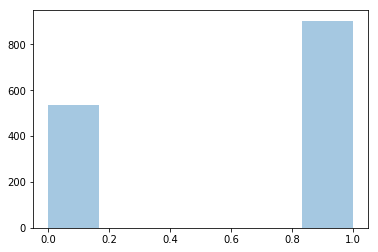

In [55]:
print("Baseline testing prediction of all seizure: ", np.sum(ylabels)/len(ylabels))
print("Baseline testing prediction of all not seizure: ", (len(ylabels)-np.sum(ylabels))/len(ylabels))

sns.distplot(ylabels, kde=False)

# fig = plt.figure()
# for i in range(len(seizonsets)):
#     xr = seizonsets[i], seizoffsets[i]
#     yr = y=i, i
# #     plt.plot(x=xr, y=yr)
#     plt.axvline(seizonsets[i], color='red')
#     plt.axvline(seizoffsets[i], color='black')
# plt.show()

(1439, 1, 32, 32)
1671.0 1671.0
(57560, 1)
7
55


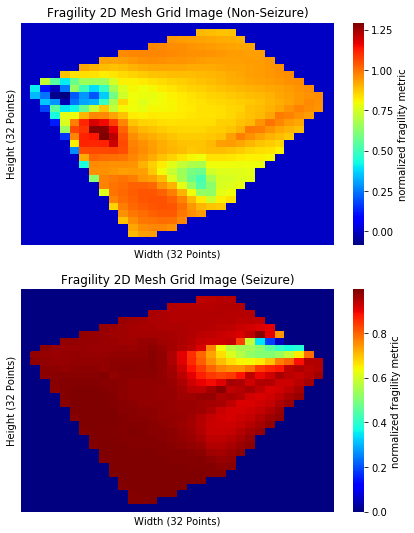

In [85]:
print(image_tensor.shape)
plt.figure(figsize=(7,9))
plt.subplot(211)
sns.heatmap(image_tensor[5,...].squeeze(), cmap='jet', cbar_kws={'label': 'normalized fragility metric'})
plt.title('Fragility 2D Mesh Grid Image (Non-Seizure)')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Height (32 Points)')
ax.set_xlabel('Width (32 Points)')

plt.subplot(212)
sns.heatmap(image_tensor[12,...].squeeze(), cmap='jet', cbar_kws={'label': 'normalized fragility metric'})
plt.title('Fragility 2D Mesh Grid Image (Seizure)')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Height (32 Points)')
ax.set_xlabel('Width (32 Points)')

print(seizonsets[0], seizoffsets[0])
print(ylabels.shape)
print(np.where(ylabels==0)[0][7])
print(np.where(ylabels==1)[0][7])

In [37]:
sns.heatmap(fragmat_2d, cmap='jet')
plt.colorbar()
plt.show()

img = Image.fromarray(data, 'RGB')
img.save('test.png')

w, h = 512, 512
data = np.random.rand(h, w, 3)
data[256, 256] = [255, 0, 0]
# img = Image.fromarray(data, 'RGB')

# data = np.divide(data, 255.)
print(np.min(data.ravel()), np.max(data.ravel())) 
img = Image.fromarray(data, 'RGB')
img.save('test.png')

img = Image.open('test.png')
print(img.size)
plt.imshow(img)

0.0 255.0


# Concatenate All 2D Images Into 1 Large Dataset

In [76]:
# Get ALL datafiles from all downstream files
trainfiles = []
for root, dirs, files in os.walk(trainimagedir):
    for file in files:
        trainfiles.append(os.path.join(root, file))
print("Train data dir is: ", datadir)
print("In traindatadir there are this many training files: ", len(trainfiles))

Train data dir is:  /Volumes/ADAM LI/pydata/tvbforwardsim/traindata
In traindatadir there are this many training files:  40


In [77]:
for idx, datafile in enumerate(trainfiles):
    data = np.load(datafile)
    imagetensor = data['image_tensor']
    metadata = data['metadata'].item()
    labels = metadata['ylabels']
    
    if idx == 0:
        ylabels = labels
        alltensors = imagetensor.reshape((imagetensor.shape[0], -1))
        print(datafile)
        print(imagetensor.shape)
        print(metadata.keys())
    else:
        alltensors = np.concatenate((alltensors, imagetensor.reshape((imagetensor.shape[0], -1))), axis=0)
        ylabels = np.concatenate((ylabels, metadata['ylabels']),axis=0)  

/Volumes/ADAM LI/pydata/dnn/traindata/fragility/fragility_2d/id001_ac_sim_x0ez-1.675_x0pz-2.04_pertmodel.npz
(1439, 1, 32, 32)
dict_keys(['seeg_contacts', 'new_locs', 'ylabels'])


In [115]:
print(sys.getsizeof(alltensors) * 1.0e-9) 
print(alltensors.shape)
print(ylabels.shape)

filename = os.path.join(trainimagedir, 'allimages_fragility2d.npz')
# np.savez_compressed(filename, images=alltensors, labels=ylabels)

0.47153163200000003
(57560, 1024)
(4943, 1)


In [118]:
data = np.load(filename)
ylabels = data['labels']

Baseline testing prediction of all seizure:  0.6854586518415566
Baseline testing prediction of all not seizure:  0.31454134815844337


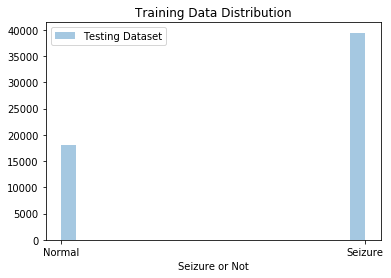

In [119]:
print("Baseline testing prediction of all seizure: ", np.sum(ylabels)/len(ylabels))
print("Baseline testing prediction of all not seizure: ", (len(ylabels)-np.sum(ylabels))/len(ylabels))

sns.distplot(ylabels, kde=False, axlabel='Seizure or Not', label='Testing Dataset')
ax=plt.gca()
ax.set_title('Training Data Distribution')
ax.set_xticks([0,1])
ax.set_xticklabels(['Normal', 'Seizure'])
ax.legend()

In [83]:
print(np.sum(ylabels) - (len(ylabels) - np.sum(ylabels)))
print(len(ylabels) - np.sum(ylabels))


21350.0
18105.0


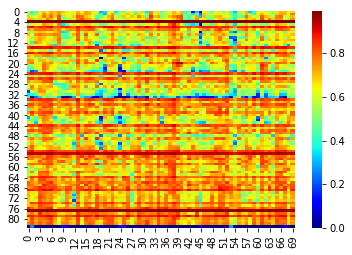

In [112]:
sns.heatmap(fragmat[:,0:70], cmap='jet')

# Convert Real Data Into Image

In [6]:
patient = 'id001_ac_sz2'
patient = 'id013_pg_sz1'
patid = patient[0:patient.find('sz')-1]
seizid = patient[patient.find('sz'):]

datadir = '/Volumes/ADAM LI/pydata/convertedtng'

chanfile =  os.path.join(datadir,  patient, patient + '_chans.csv')
headerfile = os.path.join(datadir,  patient, patient + '_headers.csv')
annotationsfile = os.path.join(datadir,  patient, patient + '_annotations.csv')

################################ 1. LOAD DATA ###########################
# instantiate a datainterface object to analyze data
patieeg = Pat.PatientIEEG(patient, clinoutcome=None, engelscore=None, logfile=None)
# get relevant channel data
included_chans, onsetchans, clinresult = fragility.util.utils.returnindices(patid, seizid)

# set metadata to be used in analysis
patieeg.setincludedchans(included_chans)
patieeg.setmetadata_fromfile(headersfile=headerfile)
patieeg.setchannels_fromfile(channelsfile=chanfile)
patieeg.setannotations_fromfile(annotationsfile=annotationsfile)

INFO:datainterface.patient:Initialized Patient IEEG object. Should run channels, metadata and annotations next!
INFO:datainterface.patient:Ran setup of meta data!
INFO:datainterface.patient:Ran setup of channels data!
INFO:datainterface.patient:Ran setup of annotations data!


In [16]:
metadatadir = os.path.join('/Volumes/ADAM LI/pydata/metadata/', patid)    
# or get labels from seeg metadata
# read in seeg file
seeg = pd.read_csv(os.path.join(metadatadir, "seeg.txt"), 
                   names=['x', 'y', 'z'], 
                   delim_whitespace=True)
seeg_labels = seeg.index
seeg_xyz = seeg.as_matrix()
locations = seeg_xyz
seeg_contacts = list(seeg_labels)

if 'id013' in patient:
    # remove these chanlabels from i013_pg
    removeset = ['A15', 'B2', 'B3', 'B8', 'C9', 'C10', 'OP10']
    # removeset = []
    chaninds = [i for i,chan in enumerate(seeg_labels) \
            if chan not in removeset]
#     print(seeg_contacts[chaninds])
    print(seeg_labels[chaninds])
    print(seeg_labels[chaninds].shape)
    seeg_labels = seeg_labels[chaninds]
    locations = locations[chaninds,:]
    print(locations.shape)

Index(['TB1', 'TB2', 'TB3', 'TB4', 'TB5', 'TB6', 'TB7', 'TB8', 'TB9', 'A1',
       'A2', 'A3', 'A4', 'A5', 'A6', 'B1', 'B4', 'B5', 'B6', 'B7', 'B9', 'B10',
       'B11', 'OT1', 'OT2', 'OT3', 'OT4', 'OT5', 'OT6', 'OT7', 'OT8', 'OT9',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'PI1', 'PI2', 'PI3', 'PI4', 'PI5',
       'PI6', 'PI7', 'PI8', 'PI9', 'OP1', 'OP2', 'OP3', 'OP4', 'OP5', 'OP6',
       'OP7', 'OP8', 'OP9'],
      dtype='object')
(56,)
(56, 3)


In [24]:
testfile = '/Volumes/ADAM LI/pydata/dnn/testdata/fragility/pert/' + patient + '/'\
 + patient + 'pertmodel.npz'
data = np.load(testfile, encoding='bytes')
seizonsets = [patieeg.onset_time]
seizoffsets = [patieeg.offset_time]

# load results data
metadata = data['metadata'].item()
fragmat = fragilitymodel.compute_fragilitymetric(data['pertmats'])
# load time points, fragility
timepoints = data['timepoints']

# for id001_ac throw out first window
fragmat = fragmat[:,1:]
timepoints = timepoints[1:,:]

# print(data.keys())
# print(metadata.keys())
print("fragility mat shape is: ", fragmat.shape)
print("timepoints shape is: ", timepoints.shape)

###################### PERFORM IMAGE MESHING ######################
print("using pca to grid image")
new_locs = pca.fit_transform(locations)
#     print(seizonsets)
#     print(seizoffsets)
ylabels = datahandler.computelabels(np.multiply(seizonsets,500),np.multiply(seizoffsets,500), timepoints)
# ylabels = ylabels[1:]
print(np.sum(ylabels)/len(ylabels))

if len(seizonsets) <= 1 and seizonsets[0] == np.nan:
    print("skipping ", datafile)
else:
    # Tensor of size [samples, freqbands, W, H] containing generated images.
    image_tensor = datahandler.gen_images(new_locs, fragmat[:,np.newaxis,:], 
                            n_gridpoints=32, normalize=False, augment=False, 
                            pca=False, std_mult=0.1, edgeless=False)
print(image_tensor.shape)
print(ylabels.shape)


/Users/adam2392/Documents/fragility_analysis/fragility/linearmodels/fragilitymodels.py:426: RuntimeWarning: invalid value encountered in true_divide
  np.max(minnormpertmat[:, icol])


fragility mat shape is:  (56, 2467)
timepoints shape is:  (2467, 2)
using pca to grid image
0.4746655857316579
(2467, 56)
(2467, 1, 32, 32)7/2467nterpolating 308/2467Interpolating 438/2467Interpolating 607/2467Interpolating 789/2467Interpolating 952/2467Interpolating 1120/2467Interpolating 1298/2467Interpolating 1446/2467Interpolating 1621/2467Interpolating 1776/2467Interpolating 1936/2467Interpolating 2097/2467Interpolating 2250/2467Interpolating 2426/2467
(2467, 1)


In [25]:
# instantiate metadata hash table
metadata = dict()
metadata['seeg_contacts'] = seeg_contacts
metadata['new_locs'] = new_locs
metadata['ylabels'] = ylabels

imagefilename = os.path.join('/Users/adam2392/Downloads/', patient+'_testimages.npz')
# save image and meta data
np.savez(imagefilename, image_tensor=image_tensor, metadata=metadata)

print(imagefilename)
print(fragmat.shape)
print(seizonsets, seizoffsets)
print('\n\n')

/Users/adam2392/Downloads/id013_pg_sz1_testimages.npz
(56, 2467)
[83.09375] [228.375]





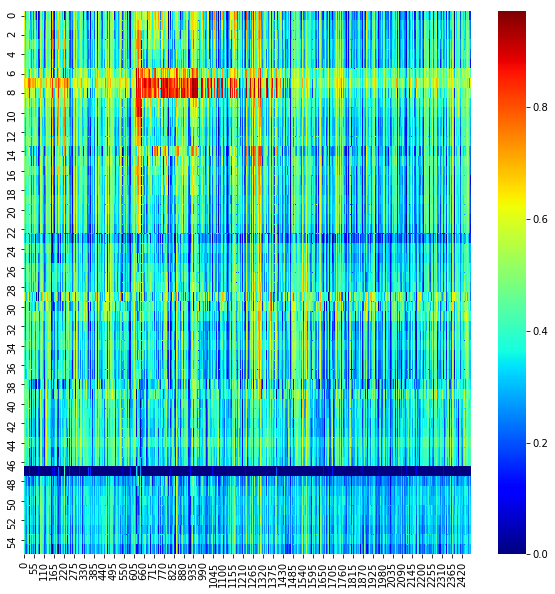

In [29]:
plt.figure(figsize=(10,10))
sns.heatmap(fragmat, cmap='jet')

(2467, 1, 32, 32)
83.09375 228.375
(2467, 1)
[   0    1    2 ... 2464 2465 2466]
[ 668  669  670 ... 1836 1837 1838]


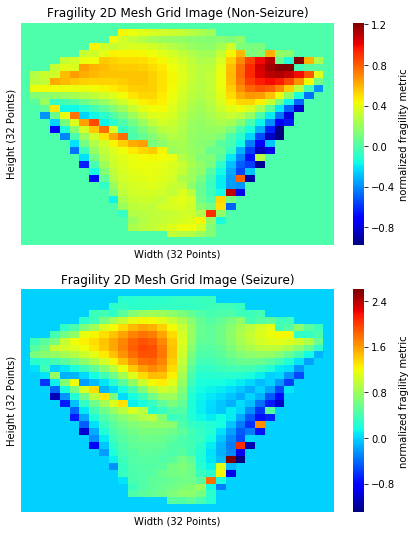

In [28]:
print(image_tensor.shape)
plt.figure(figsize=(7,9))
plt.subplot(211)
sns.heatmap(image_tensor[300,...].squeeze(), cmap='jet', cbar_kws={'label': 'normalized fragility metric'})
plt.title('Fragility 2D Mesh Grid Image (Non-Seizure)')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Height (32 Points)')
ax.set_xlabel('Width (32 Points)')

plt.subplot(212)
sns.heatmap(image_tensor[700,...].squeeze(), cmap='jet', cbar_kws={'label': 'normalized fragility metric'})
plt.title('Fragility 2D Mesh Grid Image (Seizure)')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Height (32 Points)')
ax.set_xlabel('Width (32 Points)')

print(seizonsets[0], seizoffsets[0])
print(ylabels.shape)
print(np.where(ylabels==0)[0])
print(np.where(ylabels==1)[0])

In [37]:
print(seizonsets, seizoffsets)

print(2*60+51)

[171.7539062] [532.7539062]
171


In [22]:
print(timepoints[0:5,:])

[[ 62 186]
 [124 248]
 [186 310]
 [248 372]
 [310 434]]


In [23]:
#     print(seizoffsets)
ylabels = datahandler.computelabels(np.multiply(seizonsets,500),np.multiply(seizoffsets,500), timepoints)
ylabels = ylabels[1:]
print(np.sum(ylabels)/len(ylabels))
print(ylabels.shape)
print(np.where(ylabels==0)[0])
print(np.where(ylabels==1)[0])

0.4748580697485807
(2466, 1)
[   0    1    2 ... 2463 2464 2465]
[ 667  668  669 ... 1835 1836 1837]


In [22]:
print(np.multiply(seizonsets,500))
print(np.multiply(seizoffsets,500))

[41546.875]
[114187.5]


In [41]:
print(timepoints)
print(306688/500)
print(613/60)

[[    62    186]
 [   124    248]
 [   186    310]
 ...
 [306404 306528]
 [306466 306590]
 [306528 306652]]
613.376
10.216666666666667


In [ ]:
numsignals = raw
gettimepoints(self, numsignals, numwinsamps, numstepsamps):
        # create array of indices of window start times
        timestarts = np.arange(0, numsignals-numwinsamps+1, numstepsamps)
        # create array of indices of window end times
        timeends = np.arange(numwinsamps-1, numsignals, numstepsamps)
        # create the timepoints array for entire data array
        timepoints = np.append(timestarts.reshape(len(timestarts), 1), timeends.reshape(len(timestarts), 1), axis=1)
        return timepoints